In [1]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten, GRU
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [2]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [3]:
# Read in the NEM dataset from a CSV file
df=pd.read_csv("../dataset/cleaned_NEM.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

In [4]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Close'])
df1.drop('Date', axis = 1, inplace = True)

# Split dataset (7-2-1)

---



In [5]:
# Create a MinMaxScaler object with a specified range
data = df1.values
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [6]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [7]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [9]:
# Build the model
model = Sequential()

# Add a GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another GRU layer with 50 units and return_sequences set to True
model.add(GRU(50, return_sequences=True))

# Add a final GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')

# Set the filename to use for saving the model with the correct '.keras' extension
save_model = 'save_model_7_2_1.keras'

# Create a ModelCheckpoint object to save the best model during training
best_model = ModelCheckpoint(
    filepath=save_model,
    monitor='loss',
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# Train the model using the 'fit' method
model.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=50,
    verbose=2,
    callbacks=[best_model]
)

Epoch 1/80

Epoch 1: loss improved from inf to 0.17954, saving model to save_model_7_2_1.keras
21/21 - 4s - 188ms/step - loss: 0.1795
Epoch 2/80

Epoch 2: loss improved from 0.17954 to 0.05193, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0519
Epoch 3/80

Epoch 3: loss improved from 0.05193 to 0.02913, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0291
Epoch 4/80

Epoch 4: loss improved from 0.02913 to 0.02452, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0245
Epoch 5/80

Epoch 5: loss did not improve from 0.02452
21/21 - 0s - 5ms/step - loss: 0.0248
Epoch 6/80

Epoch 6: loss did not improve from 0.02452
21/21 - 0s - 5ms/step - loss: 0.0259
Epoch 7/80

Epoch 7: loss improved from 0.02452 to 0.02397, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0240
Epoch 8/80

Epoch 8: loss did not improve from 0.02397
21/21 - 0s - 5ms/step - loss: 0.0241
Epoch 9/80

Epoch 9: loss did not improve from

In [11]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_7_2_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


In [12]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [13]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [14]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [15]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.07577392485400247, 0.07397409630123819, 0.08135350357276006, 0.08135350357276006, 0.08315333212552434]


In [16]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.09157899767160416], [0.09922708570957184], [0.10704778134822845], [0.11488787829875946], [0.12277879565954208], [0.1307518184185028], [0.13879966735839844], [0.14692437648773193], [0.1551259309053421], [0.1634046733379364], [0.17176105082035065], [0.18019524216651917], [0.18870742619037628], [0.19729763269424438], [0.2059658020734787], [0.2147117704153061], [0.22353528439998627], [0.2324359118938446], [0.24141304194927216], [0.2504660487174988], [0.2595941424369812], [0.2687962055206299], [0.2780711054801941], [0.2874175012111664], [0.296833872795105], [0.3063185513019562], [0.3158695101737976], [0.3254847526550293], [0.3351619839668274], [0.34489861130714417]]


In [17]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [18]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[34.9481295 ]
 [35.37305725]
 [35.80757508]
 [36.24317085]
 [36.6815902 ]
 [37.12457132]
 [37.57170979]
 [38.02311861]
 [38.47879695]
 [38.93876386]
 [39.40304417]
 [39.87164783]
 [40.34458475]
 [40.8218566 ]
 [41.30346007]
 [41.78938605]
 [42.27962047]
 [42.77413931]
 [43.27290863]
 [43.77589367]
 [44.28305053]
 [44.79431713]
 [45.30963055]
 [45.82891628]
 [46.35208986]
 [46.87905857]
 [47.40970982]
 [47.94393267]
 [48.48159962]
 [49.02256661]]


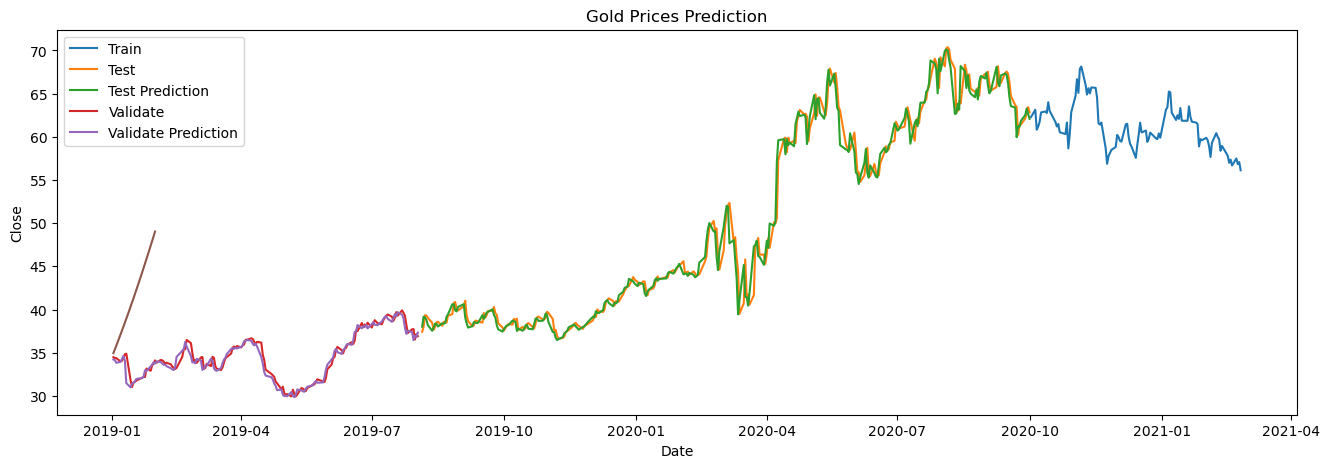

In [21]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  13.272779088587194
MAPE:  0.7330281559559046
RMSE:  17.570080355850497

** Validate **
MAE:  13.929002888997392
MAPE:  0.7273244242301433
RMSE:  18.385162038250193


# Split dataset (6-3-1)

---



In [ ]:
# Split the data
train_size = int(0.6 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
# Build the model
model = Sequential()

# Add an GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an GRU layer with 50 units
model.add(GRU(50,return_sequences=True))

# Add an GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_6_3_1.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.16410, saving model to save_model_6_3_1.hdf5
18/18 - 5s - loss: 0.1641 - 5s/epoch - 270ms/step
Epoch 2/80

Epoch 2: loss improved from 0.16410 to 0.04023, saving model to save_model_6_3_1.hdf5
18/18 - 0s - loss: 0.0402 - 152ms/epoch - 8ms/step
Epoch 3/80

Epoch 3: loss improved from 0.04023 to 0.02452, saving model to save_model_6_3_1.hdf5
18/18 - 0s - loss: 0.0245 - 149ms/epoch - 8ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02452 to 0.02302, saving model to save_model_6_3_1.hdf5
18/18 - 0s - loss: 0.0230 - 149ms/epoch - 8ms/step
Epoch 5/80

Epoch 5: loss improved from 0.02302 to 0.02100, saving model to save_model_6_3_1.hdf5
18/18 - 0s - loss: 0.0210 - 147ms/epoch - 8ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.02100
18/18 - 0s - loss: 0.0231 - 124ms/epoch - 7ms/step
Epoch 7/80

Epoch 7: loss improved from 0.02100 to 0.01886, saving model to save_model_6_3_1.hdf5
18/18 - 0s - loss: 0.0189 - 156ms/epoch - 9ms/step
Epoch

In [ ]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

27/27 [==============================] - 1s 2ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 0s 2ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 3ms/step


In [ ]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

5/5 [==============================] - 0s 4ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.892590919358482, 0.9007228371357576, 0.8746329342669981, 0.8974474813643547, 0.8958662751298849]


In [ ]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.9039114117622375], [0.9119560718536377], [0.9195300340652466], [0.9271225929260254], [0.9344183206558228], [0.9417057633399963], [0.9490119218826294], [0.9563213586807251], [0.9636135101318359], [0.970871090888977], [0.9780896306037903], [0.9852679371833801], [0.9924041032791138], [0.999494731426239], [1.0065354108810425], [1.0135217905044556], [1.0204496383666992], [1.0273154973983765], [1.0341156721115112], [1.0408464670181274], [1.0475040674209595], [1.054085373878479], [1.06058669090271], [1.0670052766799927], [1.0733379125595093], [1.0795814990997314], [1.0857332944869995], [1.0917909145355225], [1.0977517366409302], [1.1036134958267212]]


In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[1984.32316397]
 [1991.44590602]
 [1998.15189216]
 [2004.87434378]
 [2011.33398111]
 [2017.78628286]
 [2024.25515563]
 [2030.72693098]
 [2037.18340187]
 [2043.60926387]
 [2050.00055894]
 [2056.35623158]
 [2062.67459304]
 [2068.9526352 ]
 [2075.18645279]
 [2081.37219331]
 [2087.50610981]
 [2093.5851414 ]
 [2099.60601609]
 [2105.5654619 ]
 [2111.46010129]
 [2117.28719003]
 [2123.04345613]
 [2128.72647197]
 [2134.33338778]
 [2139.8614593 ]
 [2145.30825894]
 [2150.67167573]
 [2155.94938762]
 [2161.1393892 ]]


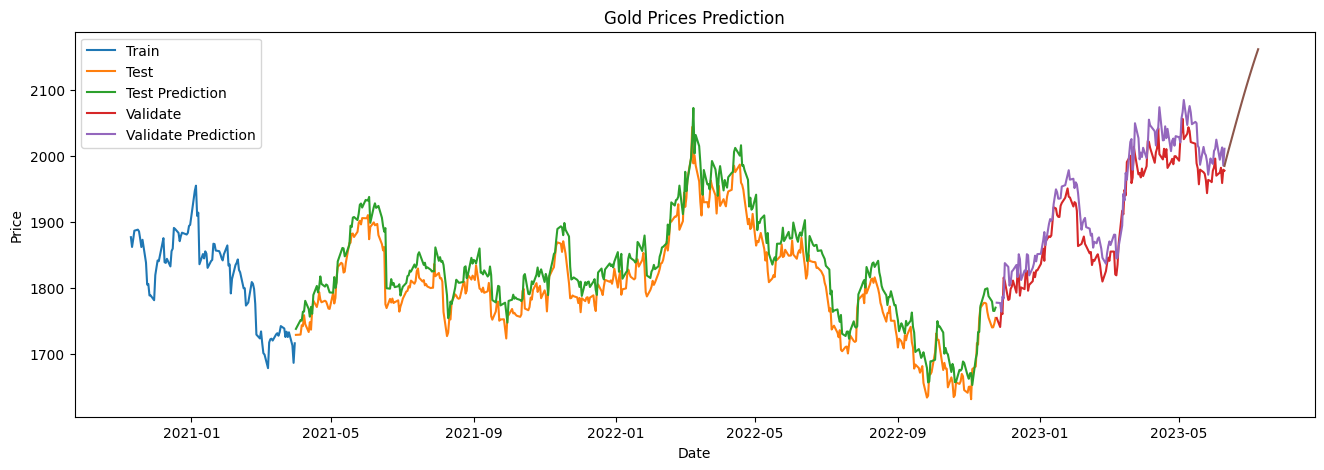

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  25.776976742333183
MAPE:  1.431951174357029
RMSE:  29.975632500001232

** Validate **
MAE:  27.55938985331075
MAPE:  1.441514269997865
RMSE:  31.601582614432058


# Split dataset (5-3-2)

---



In [ ]:
# Split the data
train_size = int(0.5 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
# Build the model
model = Sequential()

# Add an GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an GRU layer with 50 units
model.add(GRU(50,return_sequences=True))

# Add an GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_5_3_2.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.16410, saving model to save_model_5_3_2.hdf5
15/15 - 4s - loss: 0.1641 - 4s/epoch - 259ms/step
Epoch 2/80

Epoch 2: loss improved from 0.16410 to 0.05079, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0508 - 116ms/epoch - 8ms/step
Epoch 3/80

Epoch 3: loss improved from 0.05079 to 0.02662, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0266 - 134ms/epoch - 9ms/step
Epoch 4/80

Epoch 4: loss improved from 0.02662 to 0.01971, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0197 - 122ms/epoch - 8ms/step
Epoch 5/80

Epoch 5: loss improved from 0.01971 to 0.01797, saving model to save_model_5_3_2.hdf5
15/15 - 0s - loss: 0.0180 - 128ms/epoch - 9ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.01797
15/15 - 0s - loss: 0.0200 - 107ms/epoch - 7ms/step
Epoch 7/80

Epoch 7: loss did not improve from 0.01797
15/15 - 0s - loss: 0.0188 - 101ms/epoch - 7ms/step
Epoch 8/80

Epoch 8: loss improved from 0.01797 

In [ ]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_5_3_2.hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

23/23 [==============================] - 1s 2ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 0s 2ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 2ms/step


In [ ]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

9/9 [==============================] - 0s 2ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.892590919358482, 0.9007228371357576, 0.8746329342669981, 0.8974474813643547, 0.8958662751298849]


In [ ]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.9198740720748901], [0.947700023651123], [0.9762427806854248], [1.0044063329696655], [1.0318647623062134], [1.0595922470092773], [1.088008999824524], [1.1172019243240356], [1.1470447778701782], [1.1773526668548584], [1.2079708576202393], [1.238776683807373], [1.2696571350097656], [1.300488829612732], [1.3311303853988647], [1.3614259958267212], [1.3912122249603271], [1.4203258752822876], [1.4486088752746582], [1.4759153127670288], [1.502112627029419], [1.5270860195159912], [1.5507409572601318], [1.5730068683624268], [1.5938371419906616], [1.613208293914795], [1.6311205625534058], [1.6475955247879028], [1.6626720428466797], [1.6764039993286133]]


In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[1998.45650342]
 [2023.09360094]
 [2048.36535802]
 [2073.30136721]
 [2097.61306055]
 [2122.1629755 ]
 [2147.32316844]
 [2173.1705838 ]
 [2199.59344633]
 [2226.42805123]
 [2253.53739734]
 [2280.81287584]
 [2308.15442734]
 [2335.45280974]
 [2362.58284323]
 [2389.4065767 ]
 [2415.77930398]
 [2441.55652997]
 [2466.59829817]
 [2490.77541792]
 [2513.97051997]
 [2536.08196168]
 [2557.02604356]
 [2576.74028125]
 [2595.18340552]
 [2612.33462343]
 [2628.19414608]
 [2642.78107765]
 [2656.12982674]
 [2668.28810101]]


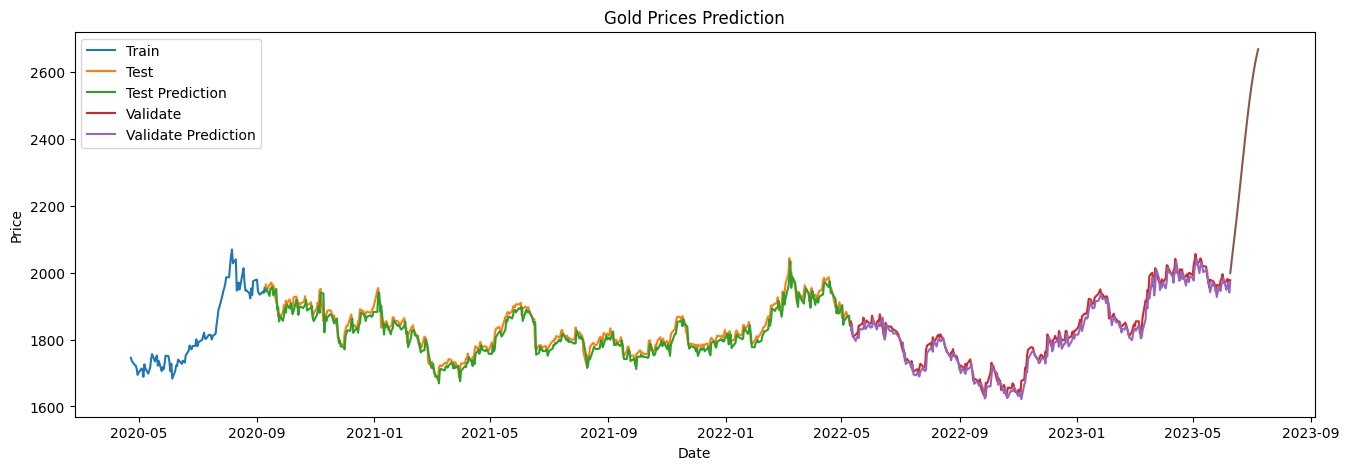

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  17.72614006273675
MAPE:  0.961849606652047
RMSE:  21.917951467316882

** Validate **
MAE:  16.84306615015844
MAPE:  0.9149163526097261
RMSE:  21.35930728289506


# Evaluating model

---

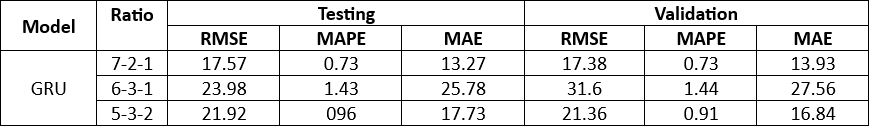